In [1]:
import pdb
import sys
import argparse
import itertools

import numpy as np
from scipy.stats import norm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sys.path.insert(0, '../../../figures')
import plot_utils as pu
import color_scheme as cs

tick_fontsize = 6
label_fontsize = 5

In [2]:
datapath1 = "data/data_a.npy"

Process data

In [3]:
state_a1, state_a2 = np.load(datapath1, allow_pickle=True, encoding='latin1')

def silent_idxs(state, threshold=0.05, t=0):
    return np.all(state.T[:,t:] < threshold, axis=1).nonzero()[0]

def active_idxs(state, threshold=0.05, t=0):
    return np.any(state.T[:,t:] > threshold, axis=1).nonzero()[0]

g = lambda x: np.argmax(x[10:])

# Neurons that are silent during recall of sequence A, but active during sequence B
silent_A_idxs = silent_idxs(state_a1)
active_B_idxs = active_idxs(state_a2)
sAaB_idxs = np.intersect1d(silent_A_idxs, active_B_idxs)
sAaB_idxs_sorted = sAaB_idxs[np.argsort([g(x) for x in state_a2.T[sAaB_idxs]])]

# Neurons that are silent during recall of sequence B, but active during sequence A
silent_B_idxs = silent_idxs(state_a2)
active_A_idxs = active_idxs(state_a1)
sBaA_idxs = np.intersect1d(silent_B_idxs, active_A_idxs)
sBaA_idxs_sorted = sBaA_idxs[np.argsort([g(x) for x in state_a1.T[sBaA_idxs]])]

# Neurons that are sequentially active during recall of sequence A, and during sequence B (at roughyl the same time)
active_A_idxs2 = active_idxs(state_a1, threshold=0.1, t=50)
active_B_idxs2 = active_idxs(state_a2, threshold=0.1, t=50)
aAaB_idxs = np.intersect1d(active_A_idxs2, active_A_idxs2)
aAaB_overlap = np.mean(abs(
    state_a1[:, aAaB_idxs] / state_a1[:, aAaB_idxs].max(axis=0) -
    state_a2[:, aAaB_idxs] / state_a2[:, aAaB_idxs].max(axis=0)),
    axis=0
)
cutoff = 0.075
aAaB_idxs_cutoff = aAaB_idxs[aAaB_overlap < cutoff]
aAaB_idxs_cutoff_sorted = aAaB_idxs_cutoff[np.argsort([g(x) for x in ((state_a1.T+state_a2.T)/2.)[aAaB_idxs_cutoff]])]

Plot

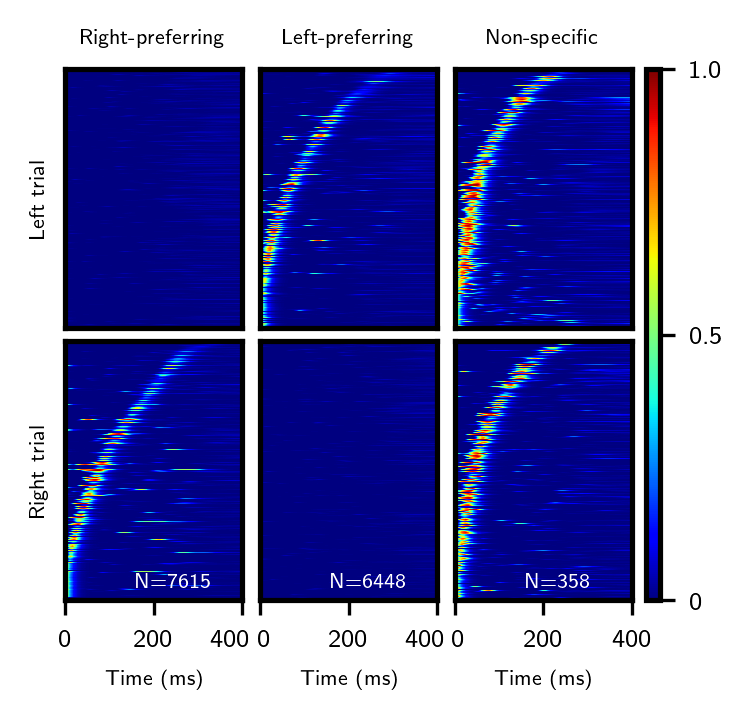

In [8]:
pu.figure_setup()
fig_size1 = pu.get_fig_size(12, 6)
fig1 = plt.figure(figsize=fig_size1)

# Panel a (selectivity comparison)
gs1 = gridspec.GridSpec(2, 3, figure=fig1)
gs1.update(left=0.05, right=0.45, top=0.9, bottom=0.15, wspace=0.1, hspace=0.05)
ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[0, 1])
ax3 = plt.subplot(gs1[0, 2])
ax4 = plt.subplot(gs1[1, 0])
ax5 = plt.subplot(gs1[1, 1])
ax6 = plt.subplot(gs1[1, 2])
cbaxis = fig1.add_axes([0.46, 0.15, 0.01, 0.75]) 

ax1.pcolormesh(state_a1.T[sAaB_idxs_sorted,:], vmin=0.0, vmax=1.0, cmap='jet', rasterized=True)
ax2.pcolormesh(state_a1.T[sBaA_idxs_sorted,:], vmin=0.0, vmax=1.0, cmap='jet', rasterized=True)
im = ax3.pcolormesh(state_a1.T[aAaB_idxs_cutoff_sorted,:][:], vmin=0.0, vmax=1.0, cmap='jet', rasterized=True)
ax4.pcolormesh(state_a2.T[sAaB_idxs_sorted,:], vmin=0.0, vmax=1.0, cmap='jet', rasterized=True)
ax5.pcolormesh(state_a2.T[sBaA_idxs_sorted,:], vmin=0.0, vmax=1.0, cmap='jet', rasterized=True)
ax6.pcolormesh(state_a2.T[aAaB_idxs_cutoff_sorted,:][:], vmin=0.0, vmax=1.0, cmap='jet', rasterized=True)

ax4.text(0.40, 0.05, "N=%i"%len(sAaB_idxs_sorted), color='white', transform=ax4.transAxes, fontsize=label_fontsize)
ax5.text(0.40, 0.05, "N=%i"%len(sBaA_idxs_sorted), color='white', transform=ax5.transAxes, fontsize=label_fontsize)
ax6.text(0.40, 0.05, "N=%i"%len(aAaB_idxs_cutoff_sorted), color='white', transform=ax6.transAxes, fontsize=label_fontsize)

ax1.set_ylabel("Left trial", fontsize=label_fontsize)
ax4.set_ylabel("Right trial", fontsize=label_fontsize)
ax1.set_title("Right-preferring", fontsize=label_fontsize)
ax2.set_title("Left-preferring", fontsize=label_fontsize)
ax3.set_title("Non-specific", fontsize=label_fontsize)

for ax in [ax4,ax5,ax6]:
    ax.set_xlabel("Time (ms)", fontsize=label_fontsize)

for ax in [ax4, ax5]:   
    dx = -3/72.; dy = 0/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig1.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels()[-1:]:
        label.set_transform(label.get_transform() + offset)

for ax in [ax5, ax6]:   
    dx = 1/72.; dy = 0/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig1.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels()[:1]:
        label.set_transform(label.get_transform() + offset)

cbar = fig1.colorbar(im, cax=cbaxis)
cbar.set_ticks([0,0.5,1.0])
cbar.set_ticklabels([0,0.5,1.0])
cbar.ax.tick_params(labelsize=tick_fontsize)

for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
for ax in [ax4,ax5,ax6]:
    ax.set_yticks([])
    ax.set_xticks([0,200,400])
    ax.set_xticklabels([0,200,400], fontsize=tick_fontsize)
    
plt.savefig("../output/5.pdf", dpi=300, bbox_inches='tight', pad_inches=0)